In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio
import os
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate

In [2]:
path = ''
image_path = os.path.join(path, './data/CameraRGB/')
mask_path = os.path.join(path, './data/CameraMask/')
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

Text(0.5, 1.0, 'Segmentation')

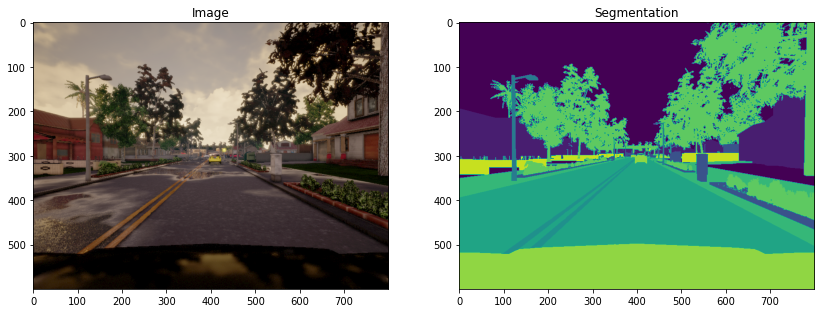

In [3]:
N = 3
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
#mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

##### Splitting Dataset into Unmasked and Masked Images

In [4]:
#To create a dataset of all files matching a pattern, use tf.data.Dataset.list_files:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraRGB\\F61-1.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraMask\\F61-1.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraRGB\\F61-10.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraMask\\F61-10.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraRGB\\F61-100.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraMask\\F61-100.png'>)


In [5]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'./data/CameraRGB/F61-1.png', shape=(), dtype=string)
tf.Tensor(b'./data/CameraMask/F61-1.png', shape=(), dtype=string)


##### Preprocessing

In [6]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    input_image = input_image / 255.

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

##### U-Net

In [7]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block | Encoder

    inputs -- Input tensor
    n_filters -- Number of filters for the convolutional layers
    dropout_prob -- Dropout probability
    max_pooling -- MaxPooling2D to reduce the spatial dimensions of the output volume
    next_layer, skip_connection --  Next layer and skip connection outputs
    """

    conv = Conv2D(n_filters, # Number of filters
                  3,# Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(inputs)
    
    conv = Conv2D(n_filters, # Number of filters
                  3,# Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(conv)
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
         
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = MaxPooling2D(2,strides=2)(conv)
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [10]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block | Decoder
    
    expansive_input -- Input tensor from previous layer
    contractive_input -- Input tensor from previous skip layer
    n_filters -- Number of filters for the convolutional layers
    conv -- Tensor output
    """

    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,# Kernel size
                 strides=2,
                 padding='same')(expansive_input)
    
    # Merging the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    
    conv = Conv2D(n_filters, # Number of filters
                  3,# Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(merge)
        
    conv = Conv2D(n_filters, # Number of filters
                  3,# Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(conv)
    
    return conv

In [12]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    """
    U-Net model
    
    input_size -- Input shape 
    n_filters -- Number of filters for the convolutional layers
    n_classes -- Number of output classes
    model -- tf.keras.Model
    """
    inputs = Input(input_size)

    # Contracting Path (encoding)
    # Conv_block with the inputs of the unet_ model and n_filters
    cblock1 = conv_block(inputs=inputs, n_filters=n_filters*1)
    # Chaining the first element of the output of each block to be the input of the next conv_block. 
    # Doubling the number of filters at each new step
    cblock2 = conv_block(inputs=cblock1[0], n_filters=n_filters*2)
    cblock3 = conv_block(inputs=cblock2[0], n_filters=n_filters*4)
    # Including a dropout of 0.3 for this layer
    cblock4 = conv_block(inputs=cblock3[0], n_filters=n_filters*8,dropout_prob=0.3)
    # Including a dropout of 0.3 for this layer, and avoiding the max_pooling layer
    cblock5 = conv_block(inputs=cblock4[0], n_filters=n_filters*16,dropout_prob=0.3, max_pooling=False) 
    
    # Expanding Path (decoding)
    # First, upsampling_block.
    # From here, at each step, half the number of filters of the previous block will be used.
    # Using the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters*8)
    # Chaining the output of the previous block as expansive_input and the corresponding contractive block output.
    # We must use the second element of the contractive block i.e before the maxpooling layer. 
    
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters*1)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    # Adding a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [13]:
# Setting model dimensions
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

In [14]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 128, 3)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 128, 32)  896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 128, 32)  9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 48, 64, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [15]:
'''
In semantic segmentation, we need as many masks as object classes. In the dataset, each pixel in every 
mask has been assigned a single integer probability that it belongs to a certain class [0 to num_classes-1]. 
The correct class is the layer with the higher probability. This is different from categorical crossentropy, 
where the labels should be one-hot encoded (just 0s and 1s). 
Here, we'll use sparse categorical crossentropy as loss function, to perform pixel-wise multiclass prediction. 
Sparse categorical crossentropy is more efficient than other loss functions when dealing with lots of classes.
'''

unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(600, 800, 1)


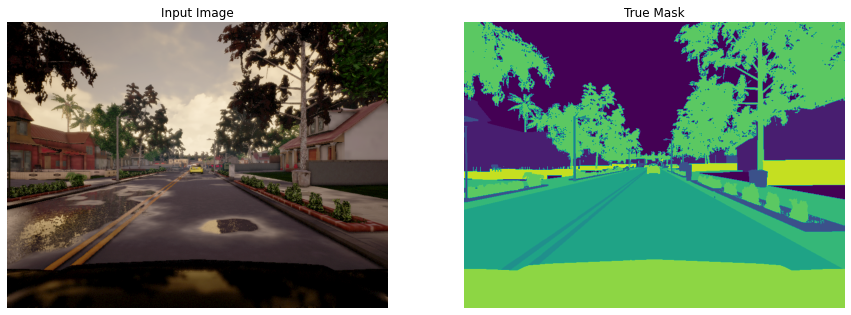

In [17]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(96, 128, 1)


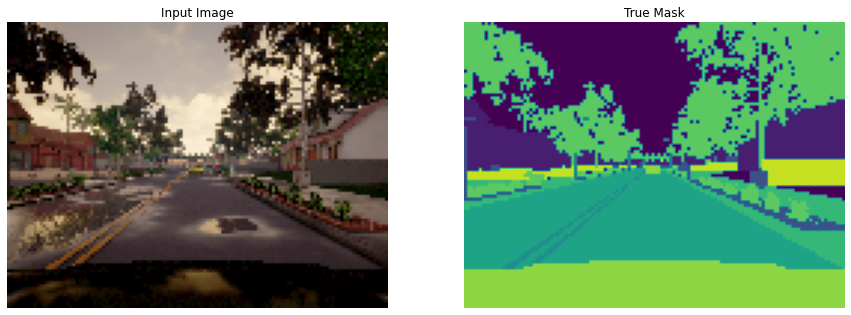

In [18]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

In [19]:
EPOCHS = 10
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
processed_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/10
32/32 [==============================] - 323s 10s/step - loss: 3.0887 - accuracy: 0.2541
Epoch 2/10
32/32 [==============================] - 302s 9s/step - loss: 2.1333 - accuracy: 0.2958
Epoch 3/10
32/32 [==============================] - 340s 11s/step - loss: 1.2543 - accuracy: 0.5568
Epoch 4/10
32/32 [==============================] - 333s 10s/step - loss: 0.8500 - accuracy: 0.6836
Epoch 5/10
32/32 [==============================] - 349s 11s/step - loss: 0.7635 - accuracy: 0.7227
Epoch 6/10
32/32 [==============================] - 362s 11s/step - loss: 0.6618 - accuracy: 0.7556
Epoch 7/10
32/32 [==============================] - 356s 11s/step - loss: 0.5712 - accuracy: 0.7938
Epoch 8/10
32/32 [==============================] - 355s 11s/step - loss: 0.5251 - accuracy: 0.8174
Epoch 9/10
32/32 [==============================] - 342s 11s/step - loss: 0.4698

In [20]:
# function that uses tf.argmax in the axis of the number of classes to return the
# index with the largest value and merge the prediction into a single image

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

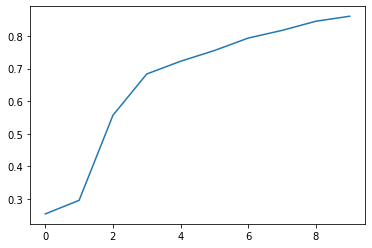

In [21]:
plt.plot(model_history.history["accuracy"])

In [22]:
def show_predictions(dataset=None, num=1):
    # Displaying the first image of each of the num batches
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

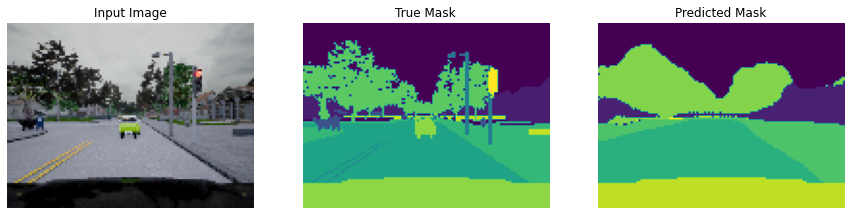

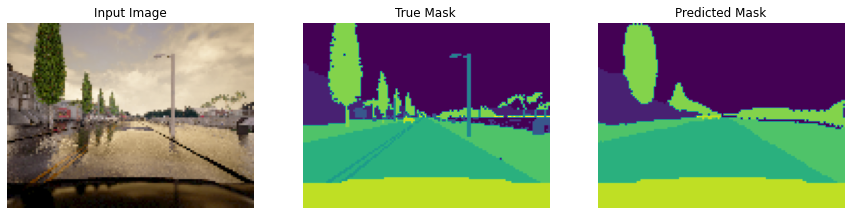

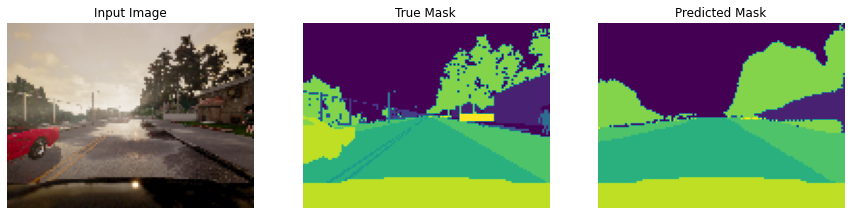

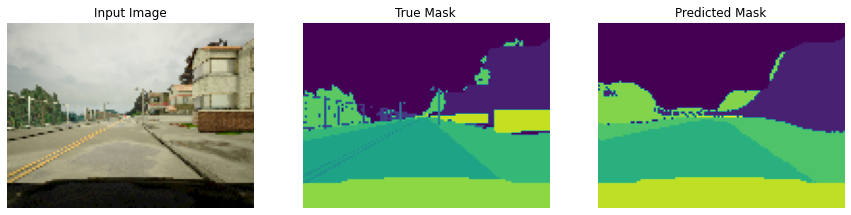

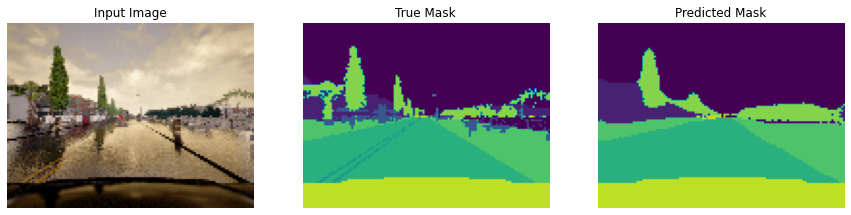

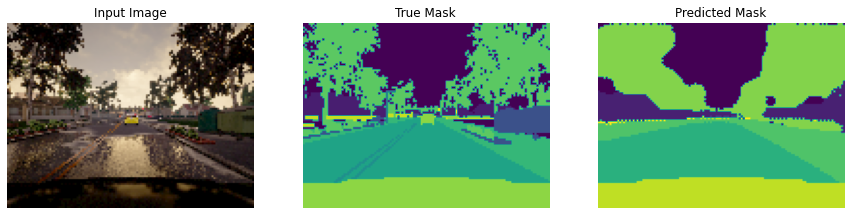

In [23]:
show_predictions(train_dataset, 6)